In [1]:
from string import punctuation
import re

import numpy as np
import pandas as pd

import nltk
from nltk.corpus import stopwords
from nltk.cluster import KMeansClusterer, euclidean_distance, cosine_distance
import sklearn
from sklearn import cluster, metrics
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.decomposition import PCA
from yellowbrick.cluster import KElbowVisualizer
import gensim
from gensim.models import Word2Vec
import torch
from pyclustertend import hopkins

/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


In [2]:
df = pd.read_csv('../data/TACR_Starfos_isvav_project.csv')
reduced_df = df[['Název anglicky', 'Anotace anglicky', 'Klíčová slova']]
all_df = df[['Kód projektu', 'Hlavní CEP obor', 'Podpora ze SR', 'Podrobné informace o účastnících']]
reduced_df.dropna(inplace=True)
reduced_df.reset_index(inplace=True)

/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [4]:
for i, x in enumerate(df.columns):
    print(f'{i} - {x}')

0 - Kód projektu
1 - Název česky
2 - Název anglicky
3 - Anotace česky
4 - Anotace anglicky
5 - Hlavní CEP obor
6 - Vedlejší CEP obor
7 - Další vedlejší CEP obor
8 - Hlavní FORD obor
9 - Vedlejší FORD obor
10 - Další vedlejší FORD obor
11 - Kategorie VaV
12 - Hlavní účastníci
13 - Další účastníci
14 - Výčet právních forem účastníků
15 - Výčet krajů účastníků
16 - Výčet zemí účastníků
17 - Podrobné informace o účastnících
18 - Hlavní řešitelé
19 - Další řešitelé
20 - Klíčová slova
21 - Výčet druhů dosažených výsledků
22 - Poskytovatel
23 - Program
24 - Uznané náklady
25 - Podpora ze SR
26 - Ostatní veřejné zdroje fin.
27 - Neveřejné zdroje fin.
28 - Začátek řešení
29 - Konec řešení
30 - URL v Starfose
31 - Relevance


In [3]:
all_df = all_df.iloc[reduced_df['index']]
reduced_df.drop(columns='index', inplace=True)
eng_df = reduced_df[~reduced_df['Klíčová slova'].str.contains('ě|š|č|ř|ž|ý|á|í|é|ů|ú|ň|ď|ť')]

all_attrs = (eng_df.iloc[:, 0] + ' ' + eng_df.iloc[:, 1] + ' ' + eng_df.iloc[:, 2]).astype(str)
names_only = (eng_df.iloc[:, 0]).astype(str)
annotation_only = (eng_df.iloc[:, 1]).astype(str)
kwords_only = (eng_df.iloc[:, 2]).astype(str)
names_annotation = (eng_df.iloc[:, 0] + ' ' + eng_df.iloc[:, 1]).astype(str)
names_kwords = (eng_df.iloc[:, 0] + ' ' + eng_df.iloc[:, 2]).astype(str)
annotation_kwords = (eng_df.iloc[:, 1] + ' ' + eng_df.iloc[:, 2]).astype(str)

experiment_data = {'all_attrs': all_attrs,
                   'names_only': names_only,
                   'annotation_only': annotation_only,
                   'kwords_only': kwords_only,
                   'names_annotation': names_annotation,
                   'names_kwords': names_kwords,
                   'annotation_kwords': annotation_kwords}

for key in list(experiment_data):
    experiment_data[f'{key}_lowercase'] = experiment_data[key].apply(lambda x: x.lower())

/home/fassty/anaconda3/envs/deep_learning/lib/python3.7/site-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [4]:
tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()

def lemmatize_text(text):
    return [lemmatizer.lemmatize(w) for w in tokenizer.tokenize(text)]

In [5]:
for key, record in experiment_data.items():
    experiment_data[key] = record.apply(lemmatize_text)

In [6]:
sw = stopwords.words('english')
sw.extend(['aim', 'project', 'evaluate', 'research', 'improve', 'improvement', 'development'])

def remove_stopwords(x):
    new_sentence = []
    for word in x:
        if word not in sw:
            new_sentence.append(word)
    return new_sentence

In [7]:
for key, record in experiment_data.items():
    experiment_data[key] = record.apply(remove_stopwords)

In [8]:
# Download Google corpus
import gensim.downloader as api

In [9]:
model = api.load('glove-wiki-gigaword-50')

In [10]:
model.vector_size

50

In [11]:
def document_vector(sentence):
    if len(sentence) == 0:
        return np.zeros(model.vector_size)
    doc = [word for word in sentence if model.has_index_for(word)]
    if len(doc) == 0:
        return np.zeros(model.vector_size)
    return np.mean(model[doc], axis=0)

In [12]:
for key, record in experiment_data.items():
    experiment_data[key] = record.apply(document_vector).to_numpy()
    experiment_data[key] = np.stack(experiment_data[key])

In [13]:
for key, record in experiment_data.items():
    res = hopkins(record, record.shape[0])
    print(f'{key}: {res}')

all_attrs: 0.11929932152507876
names_only: 0.13314019999740426
annotation_only: 0.11365769288500233
kwords_only: 0.14184708130920912


KeyboardInterrupt: 

Names and kwords lowercase has the best result... although not really satisfying

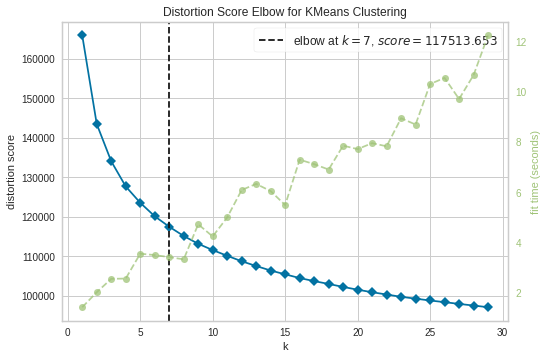

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [14]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1, 30))

visualizer.fit(experiment_data['names_kwords_lowercase'])
visualizer.show()

In [16]:
clusterer = KMeansClusterer(16, euclidean_distance)
clustered = clusterer.cluster(experiment_data['names_kwords_lowercase'], assign_clusters=True)

In [17]:
from sklearn.manifold import TSNE
tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(experiment_data['names_kwords_lowercase'])

x, y = [], []
for value in new_values:
    x.append(value[0])
    y.append(value[1])

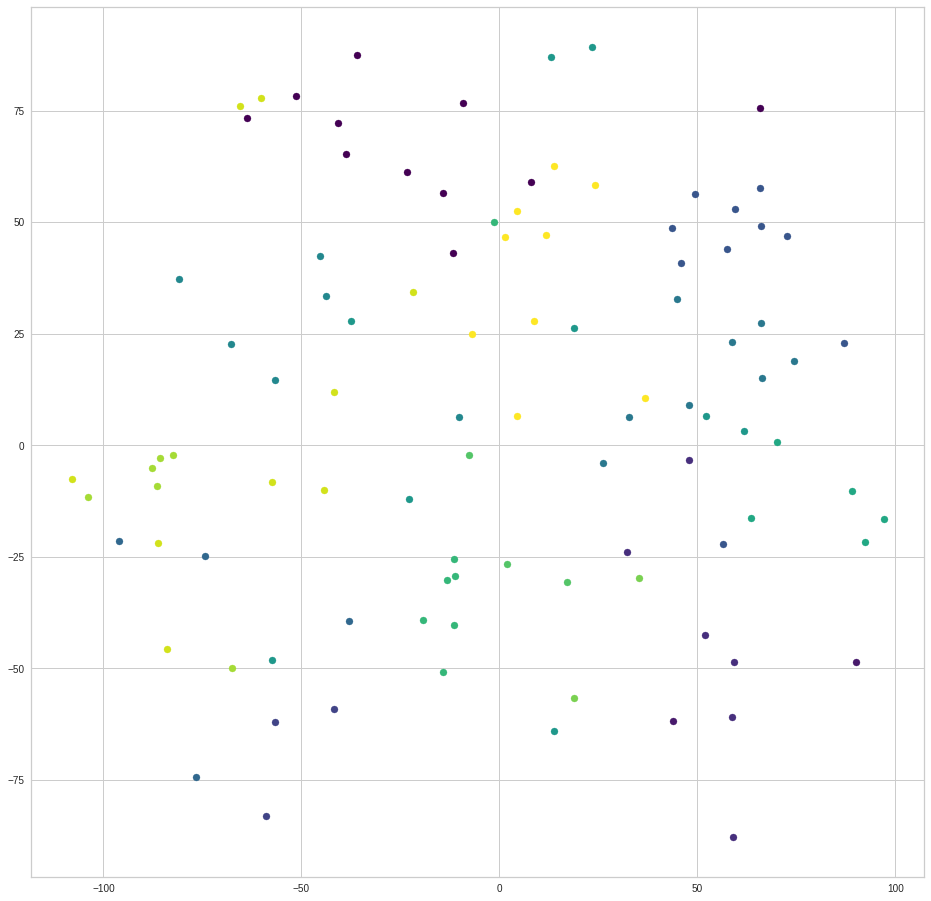

In [20]:
import matplotlib.pyplot as plt
from matplotlib import cm
import random

words = list(set(names_kwords))
index = random.sample(range(len(words) - 1), 100)

viridis = cm.get_cmap('viridis', 16)

plt.figure(figsize=(16, 16))
for i in index:
    plt.scatter(x[i],y[i], color=viridis(clustered[i] / 16))
#    plt.annotate(words[i],
#                 xy=(x[i], y[i]),
#                 xytext=(5, 2),
#                 textcoords='offset points',
#                 ha='right',
#                 va='bottom')
plt.show()

In [22]:
from IPython.display import display
clusters = {}
for i in range(16):
    index = [i for i in range(len(clustered)) if clustered[i] == 0]
    clusters[f'cluster_{i}'] = all_df.iloc[index]
    print(f'cluster_{i}: {len(index)}')
    display(clusters[f'cluster_{i}'].sample(10))

cluster_0: 2486


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
37834,ME 381,BA - Obecná matematika,388,Univerzita Karlova / Matematicko-fyzikální fak...
24927,GAP302/11/1910,EA - Morfologické obory a cytologie,6045,"Ústav molekulární genetiky AV ČR, v. v. i. (ic..."
6190,EG17_106/0012532,CI - Průmyslová chemie a chemické inženýrství,0,GrapheneUP SE (ico: 02641232; forma: POO - Prá...
44434,ORDELINF20071,KA - Vojenství,5205,"DELINFO, spol. s r.o. (ico: 49448218; forma: P..."
7743,FI-IM3/027,"JA - Elektronika a optoelektronika, elektrotec...",6200,RAMET a.s. (ico: 25638891; forma: POO - Právni...
37121,LTAUSA19142,NaN,7045,Univerzita Karlova / Přírodovědecká fakulta (i...
48902,SP/3G3/85/07,CI - Průmyslová chemie a chemické inženýrství,18750,Výzkumný ústav organických syntéz a.s. (ico: 6...
7422,FF-P2/038,CI - Průmyslová chemie a chemické inženýrství,4500,"Unipetrol výzkumně vzdělávací centrum, a.s. (i..."
318,1F84D/071/120,JO - Pozemní dopravní systémy a zařízení,5237,"KPM CONSULT, a.s. (ico: 25312936; forma: POO -..."
49952,TA04021212,CI - Průmyslová chemie a chemické inženýrství,5975,"TŘINECKÉ ŽELEZÁRNY, a. s. (ico: 18050646; form..."


cluster_1: 2486


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
5909,EG15_019/0004928,JR - Ostatní strojírenství,2899,ROMOTOP spol. s r. o. (ico: 47678186; forma: P...
41498,NS9648,FM - Hygiena,5152,Státní zdravotní ústav se sídlem v Praze (ico:...
6449,EG19_262/0019913,NaN,0,"EGÚ Brno, a.s. (ico: 46900896; forma: POO - Pr..."
2096,7E10061,BM - Fyzika pevných látek a magnetismus,3710,"Fyzikální ústav AV ČR, v. v. i. (ico: 68378271..."
47954,RN20002001005,"AQ - Bezpečnost a ochrana zdraví, člověk – stroj",400,Česká zemědělská univerzita v Praze / Fakulta ...
5858,EG15_019/0004698,"JU - Aeronautika, aerodynamika, letadla",7589,"LPS, letecké práce a služby, s.r.o. (ico: 6465..."
8625,FR-TI2/468,JQ - Strojní zařízení a nástroje,67244,KBA-Grafitec s.r.o. (ico: 15886701; forma: POO...
48912,SP/4H6/142/08,AM - Pedagogika a školství,7663,Univerzita Karlova / Centrum pro otázky životn...
42613,NV17-30753A,"EE - Mikrobiologie, virologie",9381,"Mikrobiologický ústav AV ČR, v. v. i. (ico: 61..."
8737,FR-TI3/244,DJ - Znečištění a kontrola vody,9236,"DEKONTA, a.s. (ico: 25006096; forma: POO - Prá..."


cluster_2: 2486


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
29907,IAA100190902,BA - Obecná matematika,5509,"Matematický ústav AV ČR, v. v. i. (ico: 679858..."
6308,EG17_175/0015586,NaN,7269,"IMACO Group, s.r.o. (ico: 25500724; forma: POO..."
9714,FV40213,NaN,12880,"Bioveta, a.s. (ico: 25304046; forma: POO - Prá..."
6143,EG17_106/0012322,JQ - Strojní zařízení a nástroje,0,"CNC Technology, spol. s r.o. (ico: 45789673; f..."
11381,GA103/08/1531,JI - Kompositní materiály,3426,České vysoké učení technické v Praze / Fakulta...
41831,NT12398,FR - Farmakologie a lékárnická chemie,2822,Univerzita Karlova / Farmaceutická fakulta v H...
41753,NT11521,"FH - Neurologie, neurochirurgie, neurovědy",3846,Fakultní nemocnice v Motole (ico: 00064203; fo...
9018,FT-TA/022,"JG - Hutnictví, kovové materiály",31500,Explosia a.s. (ico: 25291581; forma: POO - Prá...
7666,FI-IM2/072,JM - Inženýrské stavitelství,4875,AGE a.s. v likvidaci (ico: 45275823; forma: PO...
8691,FR-TI3/062,"FS - Lékařská zařízení, přístroje a vybavení",2580,České vysoké učení technické v Praze / Fakulta...


cluster_3: 2486


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
2606,8E18B012,NaN,975,České vysoké učení technické v Praze / Univerz...
2538,8B16008,"BH - Optika, masery a lasery",3753,Český metrologický institut (ico: 00177016; fo...
6888,EP9033,GK - Lesnictví,3600,Výzkumný ústav lesního hospodářství a myslivos...
41218,NR9400,FA - Kardiovaskulární nemoci včetně kardiochir...,2043,Institut klinické a experimentální medicíny (i...
25857,GC20-14450J,NaN,4320,"Ústav fyziky materiálů AV ČR, v. v. i. (ico: 6..."
44267,OK 430,"FQ - Veřejné zdravotnictví, sociální lékařství",295,Státní zdravotní ústav se sídlem v Praze (ico:...
2446,7H14007,"JA - Elektronika a optoelektronika, elektrotec...",2299,"Ústav teorie informace a automatizace AV ČR, v..."
47876,RM01/12/04,AD - Politologie a politické vědy,100,"Ústav mezinárodních vztahů, v.v.i. (ico: 48546..."
49017,ST20052005015,JC - Počítačový hardware a software,184,Ing. Lubomír Posker (ico: ; forma: ; adresa: )
8120,FI-IM5/235,IN - Informatika,5315,TANGER computersystems s. r. o. (ico: 47975067...


cluster_4: 2486


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
41749,NT11474,ED - Fyziologie,3400,Fakultní nemocnice Olomouc (ico: 00098892; for...
46238,QC1041,GG - Chov hospodářských zvířat,1050,Jihočeská univerzita v Českých Budějovicích (i...
41642,NS9982,FD - Onkologie a hematologie,6631,Fakultní nemocnice Královské Vinohrady (ico: 0...
8490,FR-TI1/504,"JA - Elektronika a optoelektronika, elektrotec...",5985,"AXIMA, spol. s r. o. (ico: 18825176; forma: PO..."
41590,NS9845,FG - Pediatrie,841,Fakultní nemocnice Brno (ico: 65269705; forma:...
7479,FF-P2/129,JR - Ostatní strojírenství,18700,T.F.A. alfa s.r.o. (ico: 49810219; forma: POO ...
35539,LD12031,GK - Lesnictví,1750,Mendelova univerzita v Brně / Lesnická a dřeva...
12939,GA13-15390S,DD - Geochemie,8982,Česká geologická služba (ico: 00025798; forma:...
47730,RK04P03OMG019,"AF - Dokumentace, knihovnictví, práce s inform...",277,Národní technické museum (ico: 00023299; forma...
3640,DG20P02OVV018,NaN,12368,Ústav pro studium totalitních režimů (ico: 751...


cluster_5: 2486


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
2162,7E12039,EB - Genetika a molekulární biologie,1120,"Výzkumný ústav rostlinné výroby, v.v.i. (ico: ..."
7512,FI-IM/034,GM - Potravinářství,3149,Bratři Horákové s.r.o. (ico: 45270805; forma: ...
6920,EP9175,GH - Výživa hospodářských zvířat,2347,"Výzkumný ústav výživy zvířat, s.r.o. (ico: 645..."
36183,LH12064,BA - Obecná matematika,2800,České vysoké učení technické v Praze / Fakulta...
35547,LD12048,EH - Ekologie – společenstva,1666,"Mikrobiologický ústav AV ČR, v. v. i. (ico: 61..."
41578,NS9812,FD - Onkologie a hematologie,12433,Masarykův onkologický ústav (ico: 00209805; fo...
6198,EG17_107/0012061,JC - Počítačový hardware a software,0,VirtualTraining s.r.o. (ico: 01898019; forma: ...
14717,GA17-05095S,CD - Makromolekulární chemie,7143,Univerzita Tomáše Bati ve Zlíně / Univerzitní ...
27934,GP310/09/P182,EC - Imunologie,1292,"Mikrobiologický ústav AV ČR, v. v. i. (ico: 61..."
41747,NT11465,"FN - Epidemiologie, infekční nemoci a klinická...",7121,Univerzita Karlova / 2. lékařská fakulta (ico:...


cluster_6: 2486


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
35544,LD12041,EI - Biotechnologie a bionika,1500,"Výzkumný ústav rostlinné výroby, v.v.i. (ico: ..."
7143,FC-M/25,"JE - Nejaderná energetika, spotřeba a užití en...",3000,"SIGMA Výzkumný a vývojový ústav, s.r.o. (ico: ..."
7034,FA-E3/089,"GD - Hnojení, závlahy, zpracování půdy",2640,SPL Holding a.s. (ico: 25375407; forma: POO - ...
164,1ET309920505,IN - Informatika,10088,"European Business Enterprise,a.s. (ico: 251303..."
44417,OPVTUO2006001,KA - Vojenství,10767,"VOP CZ, s.p. / lokalita VTÚO Brno (ico: 000004..."
46873,QJ1210359,"GC - Pěstování rostlin, osevní postupy",11303,"Biologické centrum AV ČR, v. v. i. (ico: 60077..."
8907,FR-TI4/210,JQ - Strojní zařízení a nástroje,17493,"TAJMAC-ZPS, a.s. (ico: 26215578; forma: POO - ..."
42611,NV17-30528A,"FB - Endokrinologie, diabetologie, metabolismu...",11156,Endokrinologický ústav (ico: 00023761; forma: ...
5541,EF18_054/0014660,NaN,1122,"INESAN, s.r.o. (ico: 24759384; forma: POO - Pr..."
8942,FR-TI4/365,"FS - Lékařská zařízení, přístroje a vybavení",26905,"APOS-AUTO, s.r.o. (ico: 47906260; forma: POO -..."


cluster_7: 2486


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
9018,FT-TA/022,"JG - Hutnictví, kovové materiály",31500,Explosia a.s. (ico: 25291581; forma: POO - Prá...
2573,8B18014,NaN,1128,Český metrologický institut (ico: 00177016; fo...
20349,GA303/09/0472,CE - Biochemie,2892,Univerzita Karlova / Přírodovědecká fakulta (i...
35942,LF15017,IN - Informatika,3811,"Industrial Technology Systems, spol. s r.o. (i..."
36002,LG13016,"CH - Jaderná a kvantová chemie, fotochemie",210,České vysoké učení technické v Praze / Fakulta...
41532,NS9718,FD - Onkologie a hematologie,4744,Fakultní nemocnice Plzeň (ico: 00669806; forma...
49261,TA01020930,CI - Průmyslová chemie a chemické inženýrství,15323,"ÚJV Řež, a. s. (ico: 46356088; forma: POO - Pr..."
1691,7AMB16AT020,"DG - Vědy o atmosféře, meteorologie",63,"Ústav fyziky atmosféry AV ČR, v. v. i. (ico: 6..."
41971,NT13631,"FH - Neurologie, neurochirurgie, neurovědy",3075,Ústřední vojenská nemocnice - Vojenská fakultn...
5269,EF16_018/0002604,BE - Teoretická fyzika,11630,Masarykova univerzita / Přírodovědecká fakulta...


cluster_8: 2486


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
5757,EG15_018/0004966,DJ - Znečištění a kontrola vody,1726,"ASIO TECH, spol. s r.o. (ico: 48910848; forma:..."
36002,LG13016,"CH - Jaderná a kvantová chemie, fotochemie",210,České vysoké učení technické v Praze / Fakulta...
5577,EF18_070/0009469,NaN,6326,Vysoké učení technické v Brně / Fakulta chemic...
41716,NT11335,"FB - Endokrinologie, diabetologie, metabolismu...",6978,Všeobecná fakultní nemocnice v Praze (ico: 000...
8601,FR-TI2/279,"JG - Hutnictví, kovové materiály",12255,České vysoké učení technické v Praze / Fakulta...
41208,NR9379,FR - Farmakologie a lékárnická chemie,2787,Univerzita Karlova / 1. lékařská fakulta (ico:...
6157,EG17_106/0012383,"JT - Pohon, motory a paliva",1957,"MVVS, spol. s r. o. (ico: 41604369; forma: POO..."
7895,FI-IM4/060,"FS - Lékařská zařízení, přístroje a vybavení",2110,BMT Medical Technology s.r.o. (ico: 46346996; ...
31891,IBS1010203,BL - Fyzika plasmatu a výboje v plynech,4920,"Fyzikální ústav AV ČR, v. v. i. (ico: 68378271..."
1123,2A-3TP1/108,CD - Makromolekulární chemie,7175,"SYNPO, akciová společnost (ico: 46504711; form..."


cluster_9: 2486


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
7938,FI-IM4/141,CD - Makromolekulární chemie,6993,VAKOS XT a.s. (ico: 25656180; forma: POO - Prá...
2552,8B17007,"BG - Jaderná, atomová a molekulová fyzika, ury...",5553,Český metrologický institut (ico: 00177016; fo...
41770,NT12067,"FQ - Veřejné zdravotnictví, sociální lékařství",2755,Fakultní nemocnice Olomouc (ico: 00098892; for...
8110,FI-IM5/215,"JG - Hutnictví, kovové materiály",8028,"REAL ECO TECHNIK, spol. s r.o. (ico: 26179113;..."
5594,EF19_073/0016713,NaN,6794,Univerzita Palackého v Olomouci / Lékařská fak...
47162,QK1910387,NaN,19572,Česká zemědělská univerzita v Praze / Fakulta ...
37127,LTC17006,DA - Hydrologie a limnologie,1405,České vysoké učení technické v Praze / Fakulta...
42900,OC 095,"JH - Keramika, žáruvzdorné materiály a skla",428,"Fyzikální ústav AV ČR, v. v. i. (ico: 68378271..."
29146,HS94/02,"AO - Sociologie, demografie",363,Sociální agentura (ico: 26540495; forma: ZSP -...
31767,IAB9021902,AB - Dějiny,999,"Orientální ústav AV ČR, v. v. i. (ico: 6837800..."


cluster_10: 2486


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
37127,LTC17006,DA - Hydrologie a limnologie,1405,České vysoké učení technické v Praze / Fakulta...
7511,FI-IM/033,"JG - Hutnictví, kovové materiály",5635,MATERIÁLOVÝ A METALURGICKÝ VÝZKUM s.r.o. (ico:...
36542,LM2015052,AH - Ekonomie,23970,"Národohospodářský ústav AV ČR, v. v. i. (ico: ..."
8370,FR-TI1/338,JR - Ostatní strojírenství,1087,"Akademie, o.p.s. (ico: 63493713; forma: OPS - ..."
6490,EG19_262/0020065,NaN,0,"ENBRA, a.s. (ico: 44015844; forma: POO - Právn..."
6187,EG17_106/0012522,JP - Průmyslové procesy a zpracování,6788,"Hansen Electric, spol. s r.o. (ico: 47973862; ..."
49981,TA04021532,GK - Lesnictví,5758,Výzkumný ústav lesního hospodářství a myslivos...
27968,GP401/09/P191,AA - Filosofie a náboženství,894,Masarykova univerzita / Filozofická fakulta (i...
44274,OK 437,"AO - Sociologie, demografie",8033,"Sociologický ústav AV ČR, v. v. i. (ico: 68378..."
44495,OSVTUO2008006,KA - Vojenství,8693,"VOP CZ, s.p. / lokalita VTÚO Brno (ico: 000004..."


cluster_11: 2486


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
40228,NJ7546,FM - Hygiena,831,Fakultní nemocnice Královské Vinohrady (ico: 0...
7453,FF-P2/079,JO - Pozemní dopravní systémy a zařízení,11068,BORCAD cz s.r.o. (ico: 25855042; forma: POO - ...
7255,FD-K2/61,JI - Kompositní materiály,20500,"LA composite, s.r.o. (ico: 64579336; forma: PO..."
5870,EG15_019/0004735,"BH - Optika, masery a lasery",9666,"Meopta - optika, s.r.o. (ico: 47677023; forma:..."
14633,GA17-02328S,BM - Fyzika pevných látek a magnetismus,5832,Masarykova univerzita / Přírodovědecká fakulta...
46822,QI91C199,"DM - Tuhý odpad a jeho kontrola, recyklace",6562,Česká zemědělská univerzita v Praze / Fakulta ...
49469,TA02020177,BC - Teorie a systémy řízení,8773,Technická univerzita v Liberci / Ústav pro nan...
8699,FR-TI3/087,FI - Traumatologie a ortopedie,6776,"MEDIN Orthopaedics, a.s. (ico: 27172538; forma..."
6153,EG17_106/0012368,JQ - Strojní zařízení a nástroje,0,DETA spol. s r. o. (ico: 47153059; forma: POO ...
5431,EF17_048/0007373,NaN,30591,Vysoká škola báňská - Technická univerzita Ost...


cluster_12: 2486


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
41488,NS9634,EB - Genetika a molekulární biologie,5986,Ústav hematologie a krevní transfúze (ico: 000...
9121,FT-TA3/014,JO - Pozemní dopravní systémy a zařízení,29293,F I T E a.s. (ico: 47674938; forma: POO - Pr...
7743,FI-IM3/027,"JA - Elektronika a optoelektronika, elektrotec...",6200,RAMET a.s. (ico: 25638891; forma: POO - Právni...
7964,FI-IM4/203,JQ - Strojní zařízení a nástroje,1845,BIC Ostrava s.r.o. (ico: 49608444; forma: POO ...
9322,FV10120,JO - Pozemní dopravní systémy a zařízení,12050,SVS FEM s.r.o. (ico: 15548180; forma: POO - Pr...
44506,OSVTUPV200701,KA - Vojenství,7972,"VOP CZ, s.p. / lokalita Vyškov (ico: 00000493;..."
36559,LM2015069,"JG - Hutnictví, kovové materiály",42047,"Ústav fyziky materiálů AV ČR, v. v. i. (ico: 6..."
5398,EF16_027/0008494,NaN,3926,"Archeologický ústav AV ČR, Praha, v. v. i. (ic..."
47698,RK01P03OMG035,EG - Zoologie,115,"Muzeum Komenského v Přerově, příspěvková organ..."
21719,GA403/08/1229,"AO - Sociologie, demografie",2821,Univerzita Jana Evangelisty Purkyně v Ústí nad...


cluster_13: 2486


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
6313,EG17_175/0015593,NaN,0,SAITECH s.r.o. (ico: 25010352; forma: POO - Pr...
6975,FA-E2/058,"JB - Senzory, čidla, měření a regulace",3000,UVB TECHNIK s.r.o. (ico: 25818180; forma: POO ...
5719,EG15_018/0004614,"JE - Nejaderná energetika, spotřeba a užití en...",12236,"ELGAS, s.r.o. (ico: 47469978; forma: POO - Prá..."
47113,QK1910070,NaN,19995,Jihočeská univerzita v Českých Budějovicích / ...
9174,FT-TA3/104,"JU - Aeronautika, aerodynamika, letadla",8118,Ministerstvo obrany / Univerzita obrany - Faku...
8818,FR-TI3/553,JI - Kompositní materiály,6722,5M s.r.o. (ico: 46969250; forma: POO - Právnic...
5912,EG15_019/0004948,JC - Počítačový hardware a software,4647,CleverTech s.r.o. (ico: 27224325; forma: POO -...
5338,EF16_025/0007417,NaN,59198,"Biologické centrum AV ČR, v. v. i. (ico: 60077..."
40938,NR8519,"FB - Endokrinologie, diabetologie, metabolismu...",3247,Endokrinologický ústav (ico: 00023761; forma: ...
5295,EF16_018/0002735,"BB - Aplikovaná statistika, operační výzkum",14281,Univerzita Jana Evangelisty Purkyně v Ústí nad...


cluster_14: 2486


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
8602,FR-TI2/280,JQ - Strojní zařízení a nástroje,23328,Konstrukční oceli a.s. (ico: 25064266; forma: ...
41567,NS9786,FR - Farmakologie a lékárnická chemie,2184,Všeobecná fakultní nemocnice v Praze (ico: 000...
11824,GA104/09/1357,CD - Makromolekulární chemie,966,Vysoká škola chemicko-technologická v Praze / ...
46807,QI91A238,GG - Chov hospodářských zvířat,13500,Veterinární a farmaceutická univerzita Brno / ...
28667,GPP401/11/P097,AA - Filosofie a náboženství,658,Západočeská univerzita v Plzni / Fakulta filoz...
5824,EG15_019/0004574,JJ - Ostatní materiály,12678,"HPH, spol.s r.o. (ico: 62957473; forma: POO - ..."
854,1P05OC043,DK - Kontaminace a dekontaminace půdy včetně p...,1443,"AGRITEC, výzkum, šlechtění a služby, s.r.o. (i..."
6899,EP9090,GK - Lesnictví,8100,Výzkumný ústav lesního hospodářství a myslivos...
40943,NR8528,FJ - Chirurgie včetně transplantologie,4274,Univerzita Karlova / 3. lékařská fakulta (ico:...
9247,FT-TA4/100,JC - Počítačový hardware a software,9703,České vysoké učení technické v Praze / Fakulta...


cluster_15: 2486


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
12817,GA13-06943S,EB - Genetika a molekulární biologie,19576,"Biofyzikální ústav AV ČR, v. v. i. (ico: 68081..."
7408,FF-P2/020,"JG - Hutnictví, kovové materiály",18298,"SVOS, spol. s r.o. (ico: 48152056; forma: POO ..."
9446,FV10756,JI - Kompositní materiály,3055,MVDr. Jiří Pantůček (ico: 66578281; forma: FOI...
5872,EG15_019/0004738,DJ - Znečištění a kontrola vody,4411,"NANOPROGRES,z.s.p.o. (ico: 72070382; forma: ZS..."
7412,FF-P2/025,EG - Zoologie,2199,MediTox s.r.o. (ico: 25926713; forma: POO - Pr...
41994,NT13711,FA - Kardiovaskulární nemoci včetně kardiochir...,6018,Fakultní nemocnice Královské Vinohrady (ico: 0...
30797,IAA4055103,CE - Biochemie,786,"Ústav organické chemie a biochemie AV ČR, v. v..."
36767,LP0042,"JD - Využití počítačů, robotika a její aplikace",375,České vysoké učení technické v Praze / Fakulta...
164,1ET309920505,IN - Informatika,10088,"European Business Enterprise,a.s. (ico: 251303..."
44723,OWVVU20180006,NaN,54579,"Vojenský výzkumný ústav, s.p. (ico: 29372259; ..."


# Agglomerative clustering

In [38]:
clusterer = AgglomerativeClustering(16)
clustered = clusterer.fit_predict(experiment_data['names_kwords_lowercase'][:1000])

In [39]:
clustered

array([ 1,  1,  1,  3,  1,  7,  1,  1,  1,  1,  1,  1,  8,  8,  8,  1,  1,
        1,  1,  1,  1,  1,  8,  1,  1,  1,  1, 10,  1,  7,  1,  3,  1,  8,
        1,  1,  1,  1,  3,  3,  1,  1,  1,  1,  3,  1,  1,  1,  1,  1,  1,
        1,  7,  2,  2,  2,  2,  2,  2,  2,  2,  3,  8,  2,  2, 15, 12,  2,
        8,  2,  2, 12,  2, 12, 15, 15,  3,  4, 15,  2, 12, 12,  2,  2, 11,
        5,  5,  5,  5,  5,  6,  1,  5,  5,  6,  6,  3,  5,  5,  5,  6,  6,
        5,  6,  6,  2,  5,  6,  6,  5,  5,  6,  5,  5, 11,  5,  6,  6,  6,
        5,  5,  6,  6, 14,  8, 13,  5, 11, 13,  6,  6,  6,  6,  6, 11, 13,
        5,  1,  6,  5,  5,  2,  3,  3,  3,  3,  3,  6,  6,  6,  3,  5,  0,
        5,  3,  6,  3,  6,  5, 15, 10, 10,  6,  2, 10, 10, 10, 10, 10, 11,
       10,  2, 10,  0, 10,  2, 10,  5, 10, 10, 10,  6, 10, 10, 10, 15, 10,
        9, 10, 10, 10, 10, 13, 11,  3, 12,  0,  3, 15, 11,  2, 10,  5,  3,
        3,  2,  2,  3, 11,  0,  7,  3,  0,  1,  0,  7, 11,  3,  0,  3,  3,
       12, 11,  3,  2, 11

In [40]:
from IPython.display import display
clusters = {}
for i in range(16):
    index = [i for i in range(len(clustered)) if clustered[i] == 0]
    clusters[f'cluster_{i}'] = all_df.iloc[index]
    print(f'cluster_{i}: {len(index)}')
    display(clusters[f'cluster_{i}'].sample(10))

cluster_0: 77


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
501,1M0501,"JU - Aeronautika, aerodynamika, letadla",349083,České vysoké učení technické v Praze / Fakulta...
518,1M0556,"JG - Hutnictví, kovové materiály",79536,Univerzita Karlova / Matematicko-fyzikální fak...
800,1P05ME818,JF - Jaderná energetika,1007,"ÚJV Řež, a. s. (ico: 46356088; forma: POO - Pr..."
729,1P05ME742,GL - Rybářství,623,Jihočeská univerzita v Českých Budějovicích / ...
605,1P04LA241,BK - Mechanika tekutin,340,Západočeská univerzita v Plzni / Fakulta stroj...
696,1P05LA257,"BG - Jaderná, atomová a molekulová fyzika, ury...",18986,České vysoké učení technické v Praze / Fakulta...
720,1P05ME733,"GF - Choroby, škůdci, plevely a ochrana rostlin",395,"Výzkumný ústav rostlinné výroby, v.v.i. (ico: ..."
883,1P05OC072,FR - Farmakologie a lékárnická chemie,522,"Biofyzikální ústav AV ČR, v. v. i. (ico: 68081..."
768,1P05ME784,BE - Teoretická fyzika,951,Univerzita Karlova / Matematicko-fyzikální fak...
431,1J019/04-DP2,"AO - Sociologie, demografie",3900,"Výzkumný ústav práce a sociálních věcí, v.v.i...."


cluster_1: 77


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
867,1P05OC056,GM - Potravinářství,1443,Vysoká škola chemicko-technologická v Praze / ...
970,1QS500510566,GE - Šlechtění rostlin,6491,"Biologické centrum AV ČR, v. v. i. (ico: 60077..."
605,1P04LA241,BK - Mechanika tekutin,340,Západočeská univerzita v Plzni / Fakulta stroj...
438,1J034/05-DP2,"AO - Sociologie, demografie",7181,"Sociologický ústav AV ČR, v. v. i. (ico: 68378..."
952,1QS400400560,CI - Průmyslová chemie a chemické inženýrství,6140,"Unipetrol výzkumně vzdělávací centrum, a.s. (i..."
982,1QS900580551,"AC - Archeologie, antropologie, etnologie",3254,"Etnologický ústav AV ČR, v. v. i. (ico: 683780..."
560,1N04144,"AF - Dokumentace, knihovnictví, práce s inform...",73986,Česká geologická služba (ico: 00025798; forma:...
865,1P05OC054,GM - Potravinářství,1443,"Výzkumný ústav rostlinné výroby, v.v.i. (ico: ..."
518,1M0556,"JG - Hutnictví, kovové materiály",79536,Univerzita Karlova / Matematicko-fyzikální fak...
718,1P05ME731,CA - Anorganická chemie,731,"Ústav experimentální botaniky AV ČR, v. v. i. ..."


cluster_2: 77


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
984,1QS900610505,AI - Jazykověda,4756,"Ústav pro jazyk český AV ČR, v. v. i. (ico: 68..."
606,1P04LA242,BF - Elementární částice a fyzika vysokých ene...,2000,Univerzita Karlova / Matematicko-fyzikální fak...
293,1F82A/035/910,JO - Pozemní dopravní systémy a zařízení,1660,"Institut Jana Pernera, o.p.s. (ico: 25916050; ..."
543,1N04058,JC - Počítačový hardware a software,37845,Masarykova univerzita / Ústav výpočetní techni...
567,1N04172,"AF - Dokumentace, knihovnictví, práce s inform...",5406,"Ústav pro českou literaturu AV ČR, v. v. i. (i..."
322,1G46034,GE - Šlechtění rostlin,8108,"Ing. Hana Jakešová, CSc. (ico: 73265748; forma..."
882,1P05OC071,FR - Farmakologie a lékárnická chemie,522,"Biofyzikální ústav AV ČR, v. v. i. (ico: 68081..."
796,1P05ME813,"JE - Nejaderná energetika, spotřeba a užití en...",301,MATERIÁLOVÝ A METALURGICKÝ VÝZKUM s.r.o. (ico:...
602,1P04LA238,BD - Teorie informace,170,České vysoké učení technické v Praze / Fakulta...
599,1P04LA235,BL - Fyzika plasmatu a výboje v plynech,16246,České vysoké učení technické v Praze / Fakulta...


cluster_3: 77


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
838,1P05OC027,GK - Lesnictví,2264,"Centrum výzkumu globální změny AV ČR, v. v. i...."
970,1QS500510566,GE - Šlechtění rostlin,6491,"Biologické centrum AV ČR, v. v. i. (ico: 60077..."
881,1P05OC070,FR - Farmakologie a lékárnická chemie,522,"Biofyzikální ústav AV ČR, v. v. i. (ico: 68081..."
763,1P05ME779,CI - Průmyslová chemie a chemické inženýrství,132,Vysoká škola chemicko-technologická v Praze / ...
430,1J018/04-DP1,"AO - Sociologie, demografie",2615,"Výzkumný ústav práce a sociálních věcí, v.v.i...."
800,1P05ME818,JF - Jaderná energetika,1007,"ÚJV Řež, a. s. (ico: 46356088; forma: POO - Pr..."
598,1P04LA234,BF - Elementární částice a fyzika vysokých ene...,4000,České vysoké učení technické v Praze / Fakulta...
982,1QS900580551,"AC - Archeologie, antropologie, etnologie",3254,"Etnologický ústav AV ČR, v. v. i. (ico: 683780..."
676,1P04OE166,DK - Kontaminace a dekontaminace půdy včetně p...,6335,AQUATIS a.s. (ico: 46347526; forma: POO - Práv...
729,1P05ME742,GL - Rybářství,623,Jihočeská univerzita v Českých Budějovicích / ...


cluster_4: 77


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
402,1H-PK2/13,FE - Ostatní obory vnitřního lékařství,6240,DEONA MEDI s.r.o. (ico: 26227266; forma: POO -...
152,1ET209920409,IN - Informatika,12051,"European Business Enterprise,a.s. (ico: 251303..."
952,1QS400400560,CI - Průmyslová chemie a chemické inženýrství,6140,"Unipetrol výzkumně vzdělávací centrum, a.s. (i..."
214,1F44K/055/050,AN - Psychologie,6349,"Centrum dopravního výzkumu, v.v.i. (ico: 44994..."
764,1P05ME780,BM - Fyzika pevných látek a magnetismus,147,Univerzita Palackého v Olomouci / Přírodovědec...
601,1P04LA237,BD - Teorie informace,240,České vysoké učení technické v Praze / Fakulta...
560,1N04144,"AF - Dokumentace, knihovnictví, práce s inform...",73986,Česká geologická služba (ico: 00025798; forma:...
796,1P05ME813,"JE - Nejaderná energetika, spotřeba a užití en...",301,MATERIÁLOVÝ A METALURGICKÝ VÝZKUM s.r.o. (ico:...
969,1QS500510558,EB - Genetika a molekulární biologie,7039,"Biologické centrum AV ČR, v. v. i. (ico: 60077..."
867,1P05OC056,GM - Potravinářství,1443,Vysoká škola chemicko-technologická v Praze / ...


cluster_5: 77


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
518,1M0556,"JG - Hutnictví, kovové materiály",79536,Univerzita Karlova / Matematicko-fyzikální fak...
859,1P05OC048,GE - Šlechtění rostlin,472,"Výzkumný ústav rostlinné výroby, v.v.i. (ico: ..."
316,1F84C/084/120,JO - Pozemní dopravní systémy a zařízení,2698,"Centrum dopravního výzkumu, v.v.i. (ico: 44994..."
212,1F44H/040/050,"AQ - Bezpečnost a ochrana zdraví, člověk – stroj",9742,DEKRA CZ a.s. (ico: 49240188; forma: POO - Prá...
570,1N04186,DB - Geologie a mineralogie,33641,Univerzita Karlova / Přírodovědecká fakulta (i...
567,1N04172,"AF - Dokumentace, knihovnictví, práce s inform...",5406,"Ústav pro českou literaturu AV ČR, v. v. i. (i..."
984,1QS900610505,AI - Jazykověda,4756,"Ústav pro jazyk český AV ČR, v. v. i. (ico: 68..."
214,1F44K/055/050,AN - Psychologie,6349,"Centrum dopravního výzkumu, v.v.i. (ico: 44994..."
547,1N04067,"AF - Dokumentace, knihovnictví, práce s inform...",35248,České vysoké učení technické v Praze / Výpočet...
800,1P05ME818,JF - Jaderná energetika,1007,"ÚJV Řež, a. s. (ico: 46356088; forma: POO - Pr..."


cluster_6: 77


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
833,1P05OC022,"JG - Hutnictví, kovové materiály",1443,SVÚM a.s. (ico: 25797000; forma: POO - Právnic...
431,1J019/04-DP2,"AO - Sociologie, demografie",3900,"Výzkumný ústav práce a sociálních věcí, v.v.i...."
867,1P05OC056,GM - Potravinářství,1443,Vysoká škola chemicko-technologická v Praze / ...
952,1QS400400560,CI - Průmyslová chemie a chemické inženýrství,6140,"Unipetrol výzkumně vzdělávací centrum, a.s. (i..."
601,1P04LA237,BD - Teorie informace,240,České vysoké učení technické v Praze / Fakulta...
432,1J020/04-DP1,"AE - Řízení, správa a administrativa",14394,"Národní vzdělávací fond, o.p.s. (ico: 25751417..."
762,1P05ME778,"DG - Vědy o atmosféře, meteorologie",50,"Geofyzikální ústav AV ČR, v. v. i. (ico: 67985..."
599,1P04LA235,BL - Fyzika plasmatu a výboje v plynech,16246,České vysoké učení technické v Praze / Fakulta...
683,1P04OK458,"AE - Řízení, správa a administrativa",2250,"Ústav teorie informace a automatizace AV ČR, v..."
723,1P05ME736,JP - Průmyslové procesy a zpracování,373,Univerzita Tomáše Bati ve Zlíně / Fakulta tech...


cluster_7: 77


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
233,1F51D/119/120,JO - Pozemní dopravní systémy a zařízení,1691,AF-CITYPLAN s.r.o. (ico: 47307218; forma: POO...
838,1P05OC027,GK - Lesnictví,2264,"Centrum výzkumu globální změny AV ČR, v. v. i...."
432,1J020/04-DP1,"AE - Řízení, správa a administrativa",14394,"Národní vzdělávací fond, o.p.s. (ico: 25751417..."
832,1P05OC021,"JG - Hutnictví, kovové materiály",722,Výzkumný a zkušební ústav Plzeň s.r.o. (ico: 4...
969,1QS500510558,EB - Genetika a molekulární biologie,7039,"Biologické centrum AV ČR, v. v. i. (ico: 60077..."
676,1P04OE166,DK - Kontaminace a dekontaminace půdy včetně p...,6335,AQUATIS a.s. (ico: 46347526; forma: POO - Práv...
791,1P05ME807,"JH - Keramika, žáruvzdorné materiály a skla",220,Univerzita Pardubice / Fakulta chemicko-techno...
865,1P05OC054,GM - Potravinářství,1443,"Výzkumný ústav rostlinné výroby, v.v.i. (ico: ..."
322,1G46034,GE - Šlechtění rostlin,8108,"Ing. Hana Jakešová, CSc. (ico: 73265748; forma..."
718,1P05ME731,CA - Anorganická chemie,731,"Ústav experimentální botaniky AV ČR, v. v. i. ..."


cluster_8: 77


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
970,1QS500510566,GE - Šlechtění rostlin,6491,"Biologické centrum AV ČR, v. v. i. (ico: 60077..."
658,1P04OCP11.004,"JA - Elektronika a optoelektronika, elektrotec...",910,"Ústav fotoniky a elektroniky AV ČR, v. v. i. (..."
437,1J032/05-DP1,AH - Ekonomie,2263,Vysoká škola ekonomická v Praze / Fakulta mezi...
605,1P04LA241,BK - Mechanika tekutin,340,Západočeská univerzita v Plzni / Fakulta stroj...
293,1F82A/035/910,JO - Pozemní dopravní systémy a zařízení,1660,"Institut Jana Pernera, o.p.s. (ico: 25916050; ..."
152,1ET209920409,IN - Informatika,12051,"European Business Enterprise,a.s. (ico: 251303..."
865,1P05OC054,GM - Potravinářství,1443,"Výzkumný ústav rostlinné výroby, v.v.i. (ico: ..."
430,1J018/04-DP1,"AO - Sociologie, demografie",2615,"Výzkumný ústav práce a sociálních věcí, v.v.i...."
560,1N04144,"AF - Dokumentace, knihovnictví, práce s inform...",73986,Česká geologická služba (ico: 00025798; forma:...
763,1P05ME779,CI - Průmyslová chemie a chemické inženýrství,132,Vysoká škola chemicko-technologická v Praze / ...


cluster_9: 77


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
489,1K05015,"CB - Analytická chemie, separace",393,"Výzkumný ústav pro chov skotu, s.r.o. (ico: 49..."
984,1QS900610505,AI - Jazykověda,4756,"Ústav pro jazyk český AV ČR, v. v. i. (ico: 68..."
881,1P05OC070,FR - Farmakologie a lékárnická chemie,522,"Biofyzikální ústav AV ČR, v. v. i. (ico: 68081..."
718,1P05ME731,CA - Anorganická chemie,731,"Ústav experimentální botaniky AV ČR, v. v. i. ..."
764,1P05ME780,BM - Fyzika pevných látek a magnetismus,147,Univerzita Palackého v Olomouci / Přírodovědec...
601,1P04LA237,BD - Teorie informace,240,České vysoké učení technické v Praze / Fakulta...
432,1J020/04-DP1,"AE - Řízení, správa a administrativa",14394,"Národní vzdělávací fond, o.p.s. (ico: 25751417..."
593,1P04LA229,BD - Teorie informace,170,České vysoké učení technické v Praze / Fakulta...
437,1J032/05-DP1,AH - Ekonomie,2263,Vysoká škola ekonomická v Praze / Fakulta mezi...
560,1N04144,"AF - Dokumentace, knihovnictví, práce s inform...",73986,Česká geologická služba (ico: 00025798; forma:...


cluster_10: 77


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
833,1P05OC022,"JG - Hutnictví, kovové materiály",1443,SVÚM a.s. (ico: 25797000; forma: POO - Právnic...
567,1N04172,"AF - Dokumentace, knihovnictví, práce s inform...",5406,"Ústav pro českou literaturu AV ČR, v. v. i. (i..."
593,1P04LA229,BD - Teorie informace,170,České vysoké učení technické v Praze / Fakulta...
999,2A-1TP1/010,CD - Makromolekulární chemie,3129,"POLYMER INSTITUTE BRNO, spol. s r.o. (ico: 607..."
984,1QS900610505,AI - Jazykověda,4756,"Ústav pro jazyk český AV ČR, v. v. i. (ico: 68..."
876,1P05OC065,FR - Farmakologie a lékárnická chemie,2526,Univerzita Palackého v Olomouci / Lékařská fak...
322,1G46034,GE - Šlechtění rostlin,8108,"Ing. Hana Jakešová, CSc. (ico: 73265748; forma..."
436,1J028/04-DP2,"AO - Sociologie, demografie",27738,Masarykova univerzita / Fakulta sociálních stu...
316,1F84C/084/120,JO - Pozemní dopravní systémy a zařízení,2698,"Centrum dopravního výzkumu, v.v.i. (ico: 44994..."
882,1P05OC071,FR - Farmakologie a lékárnická chemie,522,"Biofyzikální ústav AV ČR, v. v. i. (ico: 68081..."


cluster_11: 77


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
832,1P05OC021,"JG - Hutnictví, kovové materiály",722,Výzkumný a zkušební ústav Plzeň s.r.o. (ico: 4...
543,1N04058,JC - Počítačový hardware a software,37845,Masarykova univerzita / Ústav výpočetní techni...
597,1P04LA233,BF - Elementární částice a fyzika vysokých ene...,2000,České vysoké učení technické v Praze / Ústav t...
718,1P05ME731,CA - Anorganická chemie,731,"Ústav experimentální botaniky AV ČR, v. v. i. ..."
599,1P04LA235,BL - Fyzika plasmatu a výboje v plynech,16246,České vysoké učení technické v Praze / Fakulta...
547,1N04067,"AF - Dokumentace, knihovnictví, práce s inform...",35248,České vysoké učení technické v Praze / Výpočet...
876,1P05OC065,FR - Farmakologie a lékárnická chemie,2526,Univerzita Palackého v Olomouci / Lékařská fak...
316,1F84C/084/120,JO - Pozemní dopravní systémy a zařízení,2698,"Centrum dopravního výzkumu, v.v.i. (ico: 44994..."
501,1M0501,"JU - Aeronautika, aerodynamika, letadla",349083,České vysoké učení technické v Praze / Fakulta...
800,1P05ME818,JF - Jaderná energetika,1007,"ÚJV Řež, a. s. (ico: 46356088; forma: POO - Pr..."


cluster_12: 77


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
598,1P04LA234,BF - Elementární částice a fyzika vysokých ene...,4000,České vysoké učení technické v Praze / Fakulta...
768,1P05ME784,BE - Teoretická fyzika,951,Univerzita Karlova / Matematicko-fyzikální fak...
729,1P05ME742,GL - Rybářství,623,Jihočeská univerzita v Českých Budějovicích / ...
605,1P04LA241,BK - Mechanika tekutin,340,Západočeská univerzita v Plzni / Fakulta stroj...
599,1P04LA235,BL - Fyzika plasmatu a výboje v plynech,16246,České vysoké učení technické v Praze / Fakulta...
676,1P04OE166,DK - Kontaminace a dekontaminace půdy včetně p...,6335,AQUATIS a.s. (ico: 46347526; forma: POO - Práv...
696,1P05LA257,"BG - Jaderná, atomová a molekulová fyzika, ury...",18986,České vysoké učení technické v Praze / Fakulta...
597,1P04LA233,BF - Elementární částice a fyzika vysokých ene...,2000,České vysoké učení technické v Praze / Ústav t...
952,1QS400400560,CI - Průmyslová chemie a chemické inženýrství,6140,"Unipetrol výzkumně vzdělávací centrum, a.s. (i..."
718,1P05ME731,CA - Anorganická chemie,731,"Ústav experimentální botaniky AV ČR, v. v. i. ..."


cluster_13: 77


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
763,1P05ME779,CI - Průmyslová chemie a chemické inženýrství,132,Vysoká škola chemicko-technologická v Praze / ...
952,1QS400400560,CI - Průmyslová chemie a chemické inženýrství,6140,"Unipetrol výzkumně vzdělávací centrum, a.s. (i..."
859,1P05OC048,GE - Šlechtění rostlin,472,"Výzkumný ústav rostlinné výroby, v.v.i. (ico: ..."
152,1ET209920409,IN - Informatika,12051,"European Business Enterprise,a.s. (ico: 251303..."
560,1N04144,"AF - Dokumentace, knihovnictví, práce s inform...",73986,Česká geologická služba (ico: 00025798; forma:...
601,1P04LA237,BD - Teorie informace,240,České vysoké učení technické v Praze / Fakulta...
606,1P04LA242,BF - Elementární částice a fyzika vysokých ene...,2000,Univerzita Karlova / Matematicko-fyzikální fak...
832,1P05OC021,"JG - Hutnictví, kovové materiály",722,Výzkumný a zkušební ústav Plzeň s.r.o. (ico: 4...
797,1P05ME815,"BH - Optika, masery a lasery",691,České vysoké učení technické v Praze / Fakulta...
833,1P05OC022,"JG - Hutnictví, kovové materiály",1443,SVÚM a.s. (ico: 25797000; forma: POO - Právnic...


cluster_14: 77


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
800,1P05ME818,JF - Jaderná energetika,1007,"ÚJV Řež, a. s. (ico: 46356088; forma: POO - Pr..."
322,1G46034,GE - Šlechtění rostlin,8108,"Ing. Hana Jakešová, CSc. (ico: 73265748; forma..."
764,1P05ME780,BM - Fyzika pevných látek a magnetismus,147,Univerzita Palackého v Olomouci / Přírodovědec...
602,1P04LA238,BD - Teorie informace,170,České vysoké učení technické v Praze / Fakulta...
598,1P04LA234,BF - Elementární částice a fyzika vysokých ene...,4000,České vysoké učení technické v Praze / Fakulta...
867,1P05OC056,GM - Potravinářství,1443,Vysoká škola chemicko-technologická v Praze / ...
437,1J032/05-DP1,AH - Ekonomie,2263,Vysoká škola ekonomická v Praze / Fakulta mezi...
518,1M0556,"JG - Hutnictví, kovové materiály",79536,Univerzita Karlova / Matematicko-fyzikální fak...
761,1P05ME777,"EE - Mikrobiologie, virologie",91,Masarykova univerzita / Přírodovědecká fakulta...
865,1P05OC054,GM - Potravinářství,1443,"Výzkumný ústav rostlinné výroby, v.v.i. (ico: ..."


cluster_15: 77


,Kód projektu,Hlavní CEP obor,Podpora ze SR,Podrobné informace o účastnících
547,1N04067,"AF - Dokumentace, knihovnictví, práce s inform...",35248,České vysoké učení technické v Praze / Výpočet...
876,1P05OC065,FR - Farmakologie a lékárnická chemie,2526,Univerzita Palackého v Olomouci / Lékařská fak...
599,1P04LA235,BL - Fyzika plasmatu a výboje v plynech,16246,České vysoké učení technické v Praze / Fakulta...
218,1F44L/058/050,AM - Pedagogika a školství,11870,Centrum AMAVET - Junior Brno (ico: 65765885; f...
952,1QS400400560,CI - Průmyslová chemie a chemické inženýrství,6140,"Unipetrol výzkumně vzdělávací centrum, a.s. (i..."
882,1P05OC071,FR - Farmakologie a lékárnická chemie,522,"Biofyzikální ústav AV ČR, v. v. i. (ico: 68081..."
984,1QS900610505,AI - Jazykověda,4756,"Ústav pro jazyk český AV ČR, v. v. i. (ico: 68..."
764,1P05ME780,BM - Fyzika pevných látek a magnetismus,147,Univerzita Palackého v Olomouci / Přírodovědec...
519,1M0567,"JB - Senzory, čidla, měření a regulace",365491,"CAMEA, spol. s r.o. (ico: 60746220; forma: POO..."
214,1F44K/055/050,AN - Psychologie,6349,"Centrum dopravního výzkumu, v.v.i. (ico: 44994..."
